Saving delivery_data.csv to delivery_data (2).csv

Dataset Shape: (1000, 7)

First few rows:
             timestamp  distance_km weather_condition traffic_level  \
0  2023-01-11 23:15:00          6.4             Sunny           Low   
1  2023-01-01 14:20:00          7.9             Sunny          High   
2  2023-01-27 11:58:00         13.3             Sunny        Medium   
3  2023-02-01 01:32:00         11.8             Sunny           Low   
4  2023-01-08 20:04:00          7.8             Rainy           Low   
5  2023-01-05 08:25:00         19.7             Sunny        Medium   
6  2023-01-12 16:50:00         12.5            Cloudy          High   
7  2023-01-26 19:54:00          5.5             Sunny        Medium   
8  2023-01-16 06:02:00          2.9            Stormy        Medium   
9  2023-02-02 18:31:00          3.9            Cloudy           Low   

   package_weight  driver_rating  delivery_time_minutes  
0            -1.0            NaN                   33.0  
1        

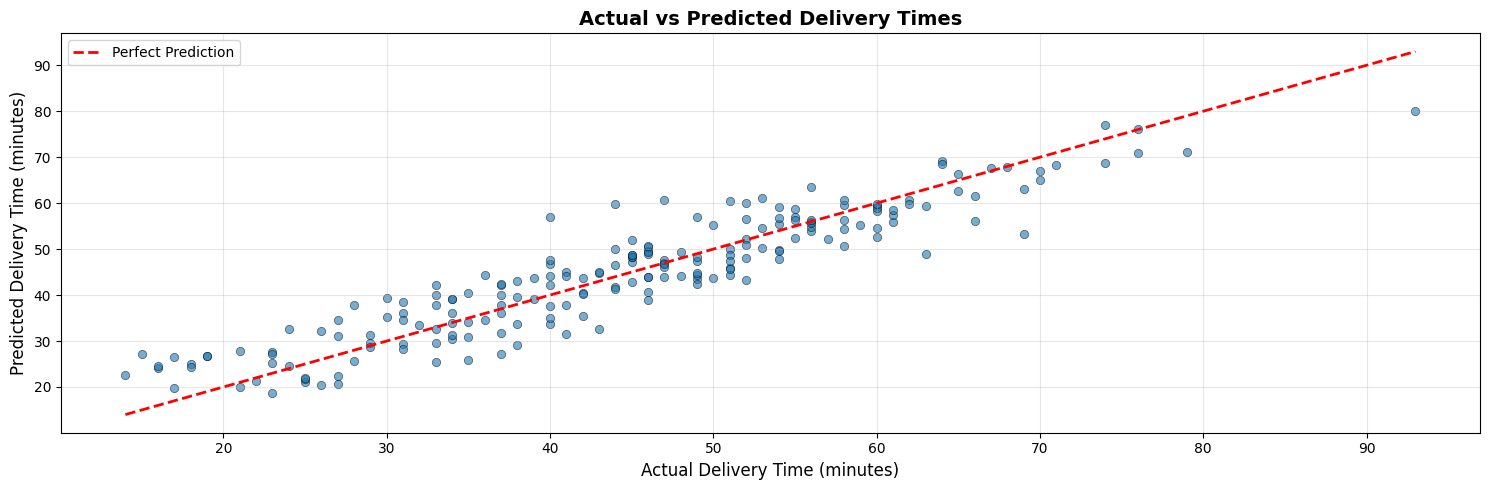


Top 10 Most Important Features:
                 feature  importance
             distance_km    0.609600
      traffic_level_High    0.155381
 weather_condition_Sunny    0.051545
weather_condition_Stormy    0.038177
 weather_condition_Rainy    0.036629
          package_weight    0.022626
weather_condition_Cloudy    0.019105
             hour_of_day    0.017852
           driver_rating    0.016999
             day_of_week    0.013964

Feature importance plot saved as 'feature_importance.png'


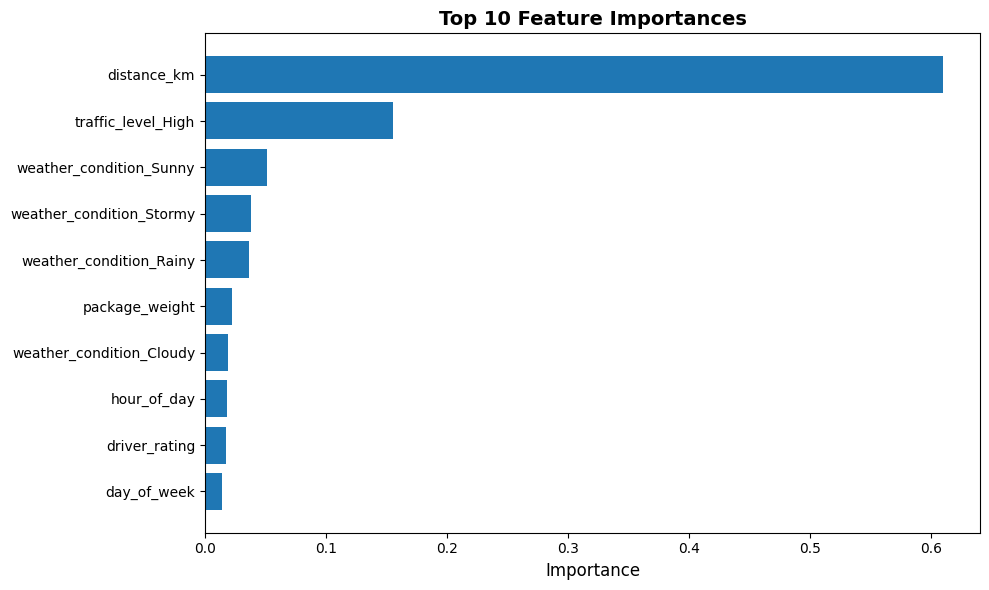

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from google.colab import files
# Set random seed for reproducibility
np.random.seed(42)
uploaded = files.upload()


# PART 1: DATA CLEANING & FEATURE ENGINEERING

# Load the data
df = pd.read_csv('delivery_data.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))

print(f"\n\nData Types:")
print(df.dtypes)

print(f"\n\nMissing Values:")
print(df.isnull().sum())

print(f"\n\nBasic Statistics:")
print(df.describe())

# Task 1: Imputing Missing Values in driver_rating

missing_count = df['driver_rating'].isnull().sum()
print(f"Missing driver_rating values: {missing_count}")

median_rating = df['driver_rating'].median()
print(f"Median driver_rating: {median_rating}")

df['driver_rating'] = df['driver_rating'].fillna(median_rating)

# Task 2: Feature Extraction from timestamp

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Feature 1: Hour of Day (delivery times likely vary by time)
df['hour_of_day'] = df['timestamp'].dt.hour

# Feature 2: Day of Week (weekend vs weekday patterns)
df['day_of_week'] = df['timestamp'].dt.dayofweek

print(f"\nUpdated Dataset Shape: {df.shape}")
print(f"\nNew columns:")
print(df[['timestamp', 'hour_of_day', 'day_of_week']].head())

# Additional Data Quality Check

negative_weights = (df['package_weight'] < 0).sum()
total_rows = len(df)
negative_pct = (negative_weights / total_rows) * 100

print(f"Rows with negative package_weight: {negative_weights} ({negative_pct:.2f}%)")


# PART 2: PIPELINE CONSTRUCTION

# Prepare features and target
X = df.drop(['delivery_time_minutes', 'timestamp'], axis=1)
y = df['delivery_time_minutes']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Define feature groups
numeric_features = ['distance_km', 'package_weight', 'driver_rating',
                   'hour_of_day', 'day_of_week']
categorical_features = ['weather_condition', 'traffic_level']

print(f"\nNumeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Create preprocessing pipelines
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline with Random Forest Regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# PART 3: EVALUATION

# Train the model
print("\nTraining the model...")
model_pipeline.fit(X_train, y_train)
print("Training complete!")

# Make predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calculate metrics

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTRAINING SET:")
print(f"  MAE:  {train_mae:.2f} minutes")
print(f"  RMSE: {train_rmse:.2f} minutes")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTEST SET:")
print(f"  MAE:  {test_mae:.2f} minutes")
print(f"  RMSE: {test_rmse:.2f} minutes")
print(f"  R²:   {test_r2:.4f}")

print(f"\nModel Performance Summary:")
print(f"  On average, predictions are off by ±{test_mae:.2f} minutes")
print(f"  Model explains {test_r2*100:.2f}% of variance in delivery times")

# ACTUAL VS PREDICTED PLOT

fig, axes = plt.subplots(figsize=(15, 5))

# Actual vs Predicted scatter plot
axes.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes.set_xlabel('Actual Delivery Time (minutes)', fontsize=12)
axes.set_ylabel('Predicted Delivery Time (minutes)', fontsize=12)
axes.set_title('Actual vs Predicted Delivery Times', fontsize=14, fontweight='bold')
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Feature Importance Analysis

# Get feature names after preprocessing
feature_names = (numeric_features +
                list(model_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features)))

importances = model_pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as 'feature_importance.png'")
plt.show()